IMPORT LIBRARIES LOAD DATA SET AND DISPLAY BASIC INFO

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('insurance_claims.csv')

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Claim_ID                  40000 non-null  object 
 1   Bind_Date1                40000 non-null  object 
 2   Customer_Life_Value1      40000 non-null  int64  
 3   Age_Insured               40000 non-null  int64  
 4   Policy_Num                40000 non-null  int64  
 5   Policy_State              40000 non-null  object 
 6   Policy_Start_Date         40000 non-null  object 
 7   Policy_Expiry_Date        40000 non-null  object 
 8   Policy_BI                 40000 non-null  object 
 9   Policy_Ded                40000 non-null  int64  
 10  Policy_Premium            40000 non-null  float64
 11  Umbrella_Limit            40000 non-null  int64  
 12  Insured_Zip               40000 non-null  int64  
 13  Gender                    40000 non-null  object 
 14  Educat

CHCEKING MISSING VALUES AND HANDLING THEM

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values - example for a few columns
df['Property_Damage'].fillna('NO', inplace=True)
df['Police_Report'].fillna('NO', inplace=True)
df['Witnesses'].fillna(0, inplace=True)

Claim_ID                        0
Bind_Date1                      0
Customer_Life_Value1            0
Age_Insured                     0
Policy_Num                      0
Policy_State                    0
Policy_Start_Date               0
Policy_Expiry_Date              0
Policy_BI                       0
Policy_Ded                      0
Policy_Premium                  0
Umbrella_Limit                  0
Insured_Zip                     0
Gender                          0
Education                       0
Occupation                      0
Hobbies                         0
Insured_Relationship            0
Capital_Gains                   0
Capital_Loss                    0
Garage_Location                 0
Accident_Date                   0
Accident_Type                   0
Collision_Type                  0
Accident_Severity               0
authorities_contacted        3600
Acccident_State                 0
Acccident_City                  0
Accident_Location               0
Accident_Hour 

CHECKING DUBLICATES AND HANDALING THEM

In [ ]:
# Check for duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Visualize duplicates (if any)
dup_counts = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})
dup_counts = dup_counts[dup_counts['count'] > 1]
if not dup_counts.empty:
    print("Duplicate records:")
    print(dup_counts)

Number of duplicates: 0


OUTLIERS AND HANDLE OUTLIERS

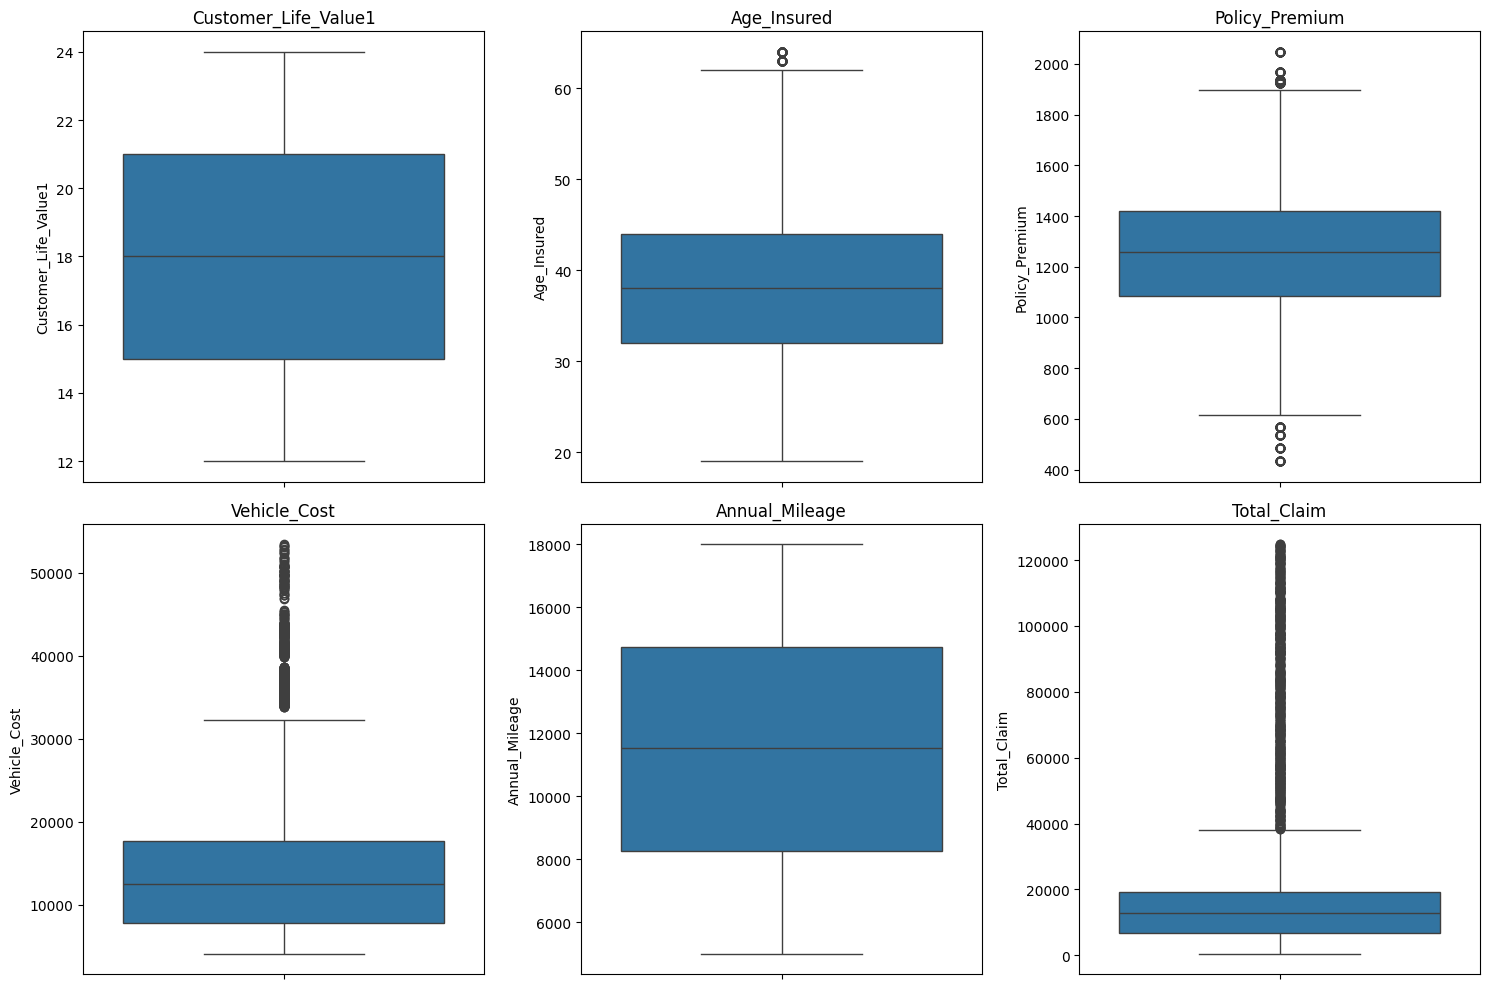

In [ ]:
# Visualize outliers for numerical columns
numerical_cols = ['Customer_Life_Value1', 'Age_Insured', 'Policy_Premium', 'Vehicle_Cost', 'Annual_Mileage', 'Total_Claim']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Handle outliers - example using IQR method for one column
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                          np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

for col in numerical_cols:
    df = handle_outliers(df, col)

DATA TRABSFORMATION

In [ ]:
# Date transformations
date_cols = ['Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Accident_Date',
             'DL_Expiry_Date', 'Claims_Date']
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
    except Exception as e:
        print(f"Error converting column {col} to datetime: {e}")
        # Optional: Investigate the problematic values
        # print(df[col][pd.to_datetime(df[col], errors='coerce').isna()])


# Feature engineering - example: claim delay
# Need to ensure Claims_Date and Accident_Date are datetime objects before this
if 'Claims_Date' in df.columns and 'Accident_Date' in df.columns:
  try:
    df['Claim_Delay'] = (df['Claims_Date'] - df['Accident_Date']).dt.days
  except Exception as e:
    print(f"Error calculating Claim_Delay: {e}")
else:
  print("Claims_Date or Accident_Date not found. Cannot calculate Claim_Delay.")


for col in date_cols:
  if col in df.columns: # Check if column exists before dropping
    df.drop(col, axis=1, inplace=True)

KPI'S CALULATION AND VISUALIZATION

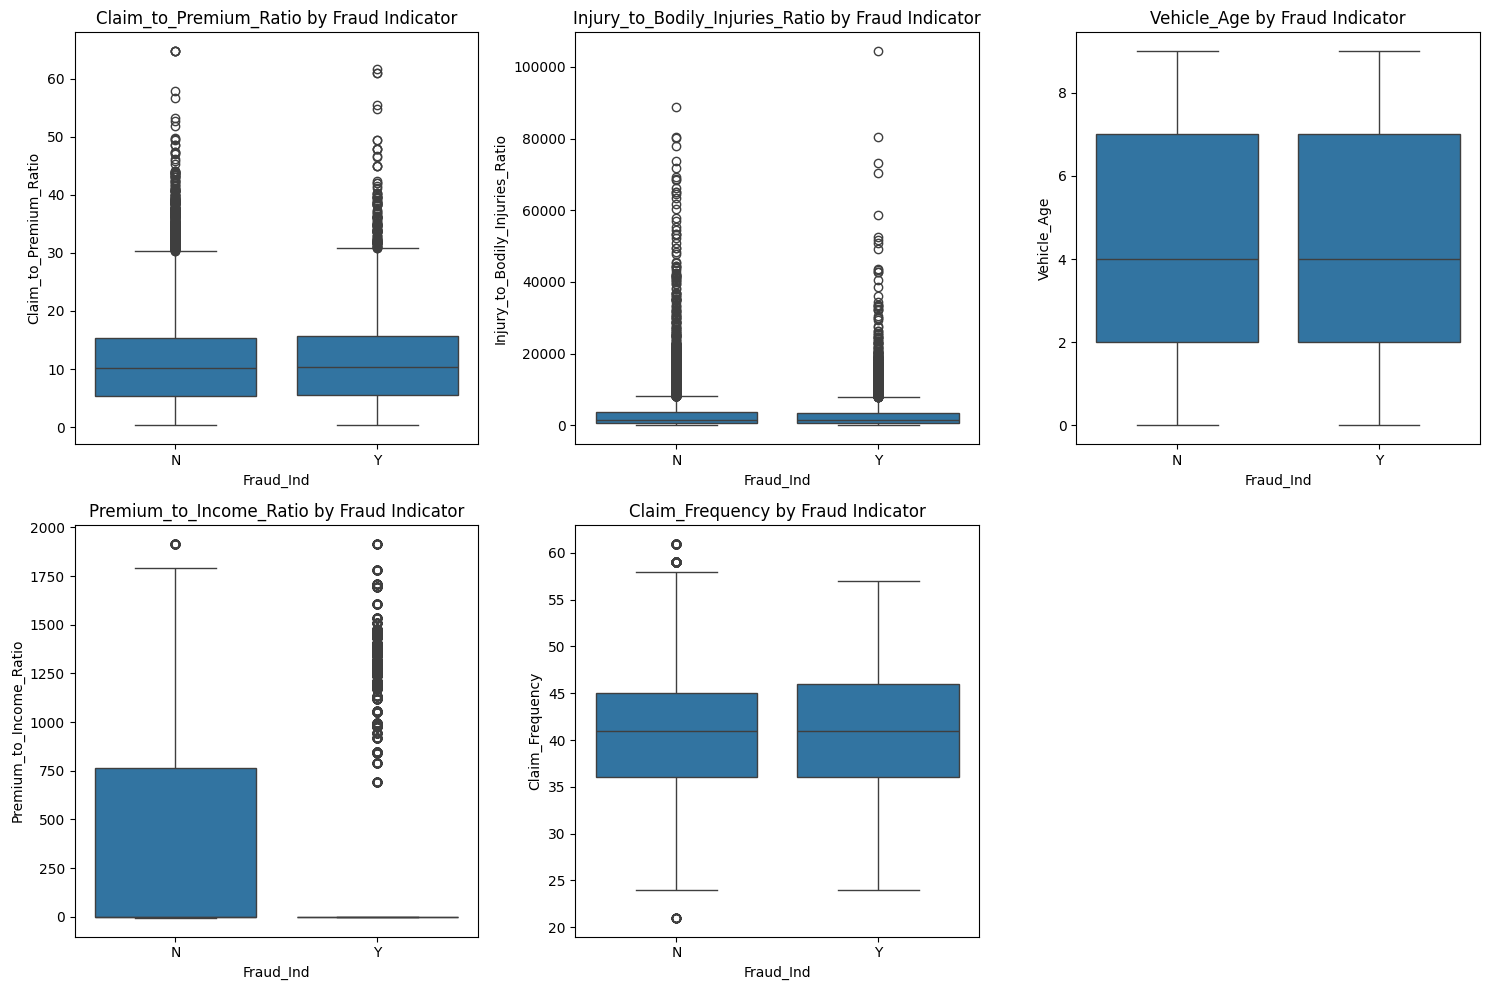

In [ ]:
# Calculate KPIs
df['Claim_to_Premium_Ratio'] = df['Total_Claim'] / df['Policy_Premium']
df['Injury_to_Bodily_Injuries_Ratio'] = df['Injury_Claim'] / (df['Bodily_Injuries'] + 1)
df['Vehicle_Age'] = df['Claims_Date_year'] - df['Auto_Year']
df['Premium_to_Income_Ratio'] = df['Policy_Premium'] / (df['Capital_Gains'] + df['Capital_Loss'] + 1)
df['Claim_Frequency'] = df.groupby('Policy_Num')['Policy_Num'].transform('count')

# Visualize KPIs
kpis = ['Claim_to_Premium_Ratio', 'Injury_to_Bodily_Injuries_Ratio',
        'Vehicle_Age', 'Premium_to_Income_Ratio', 'Claim_Frequency']

plt.figure(figsize=(15, 10))
for i, kpi in enumerate(kpis, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Fraud_Ind', y=kpi, data=df)
    plt.title(f'{kpi} by Fraud Indicator')
plt.tight_layout()
plt.show()

CONVERSTION OF CATEOGORICAL VARIABLES TO NUMERICAL

In [ ]:
# Convert categorical variables to numerical
categorical_cols = ['Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
                   'Insured_Relationship', 'Garage_Location', 'Accident_Type',
                   'Collision_Type', 'Accident_Severity', 'authorities_contacted',
                   'Property_Damage', 'Police_Report', 'Acccident_State', 'Acccident_City',
                   'Accident_Location', 'Vehicle_Color', 'Vehicle_Registration', 'Check_Point']

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle 'Policy_BI' column by splitting and converting to float
df[['Policy_BI_per_person', 'Policy_BI_per_accident']] = df['Policy_BI'].str.split('/', expand=True).astype(float)
df.drop('Policy_BI', axis=1, inplace=True)

# Select features and target
X = df.drop(['Fraud_Ind', 'Claim_ID', 'Policy_Num', 'Insured_Zip', 'Auto_Make', 'Auto_Model'], axis=1)
y = df['Fraud_Ind']

# Check for remaining object type columns in X before splitting
print("Object type columns in X before splitting:")
print(X.select_dtypes(include='object').columns)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Print data types of X_train columns to identify problematic ones
print("\nData types of columns in X_train:")
print(X_train.dtypes)

Object type columns in X before splitting:
Index([], dtype='object')

Data types of columns in X_train:
Customer_Life_Value1       float64
Age_Insured                float64
Policy_State               float64
Policy_Ded                 float64
Policy_Premium             float64
                            ...   
Vehicle_Age                float64
Premium_to_Income_Ratio    float64
Claim_Frequency            float64
Policy_BI_per_person       float64
Policy_BI_per_accident     float64
Length: 66, dtype: object


ENCODING

In [ ]:
# Select features and target
X = df.drop(['Fraud_Ind', 'Claim_ID', 'Policy_Num', 'Insured_Zip', 'Auto_Make', 'Auto_Model'], axis=1)
y = df['Fraud_Ind']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

MODEL INITIALIZATION

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Label encode y_test for metric calculation
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    y_pred_encoded = le.transform(y_pred)


    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_test_encoded, y_pred_encoded),
        'Precision': precision_score(y_test_encoded, y_pred_encoded, pos_label=1), # Specify positive label as 1
        'Recall': recall_score(y_test_encoded, y_pred_encoded, pos_label=1),       # Specify positive label as 1
        'F1': f1_score(y_test_encoded, y_pred_encoded, pos_label=1),             # Specify positive label as 1
        'AUC': roc_auc_score(y_test_encoded, y_prob),
        'Confusion Matrix': confusion_matrix(y_test_encoded, y_pred_encoded)
    }

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.sort_values(by='AUC', ascending=False))

[LightGBM] [Info] Number of positive: 6916, number of negative: 21084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4242
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677
                     Accuracy  Precision    Recall        F1       AUC  \
LightGBM             1.000000   1.000000  1.000000  1.000000  1.000000   
Random Forest        1.000000   1.000000  1.000000  1.000000  1.000000   
XGBoost              1.000000   1.000000  1.000000  1.000000  1.000000   
Decision Tree        0.999917   1.000000  0.999663  0.999831  0.999831   
KNN                  0.999333   0.998650  0.998650  0.998650  0.999828   

### Model Training and Evaluation

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=1), # Specify positive label
        'Recall': recall_score(y_test, y_pred, pos_label=1),       # Specify positive label
        'F1': f1_score(y_test, y_pred, pos_label=1),             # Specify positive label
        'AUC': roc_auc_score(y_test, y_prob),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.sort_values(by='AUC', ascending=False))

[LightGBM] [Info] Number of positive: 6916, number of negative: 21084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4242
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677
                     Accuracy  Precision    Recall        F1       AUC  \
LightGBM             1.000000   1.000000  1.000000  1.000000  1.000000   
Random Forest        1.000000   1.000000  1.000000  1.000000  1.000000   
XGBoost              1.000000   1.000000  1.000000  1.000000  1.000000   
Decision Tree        0.999917   1.000000  0.999663  0.999831  0.999831   
KNN                  0.999333   0.998650  0.998650  0.998650  0.999828   

DIFFERENT MATRICES

<Figure size 1500x800 with 0 Axes>

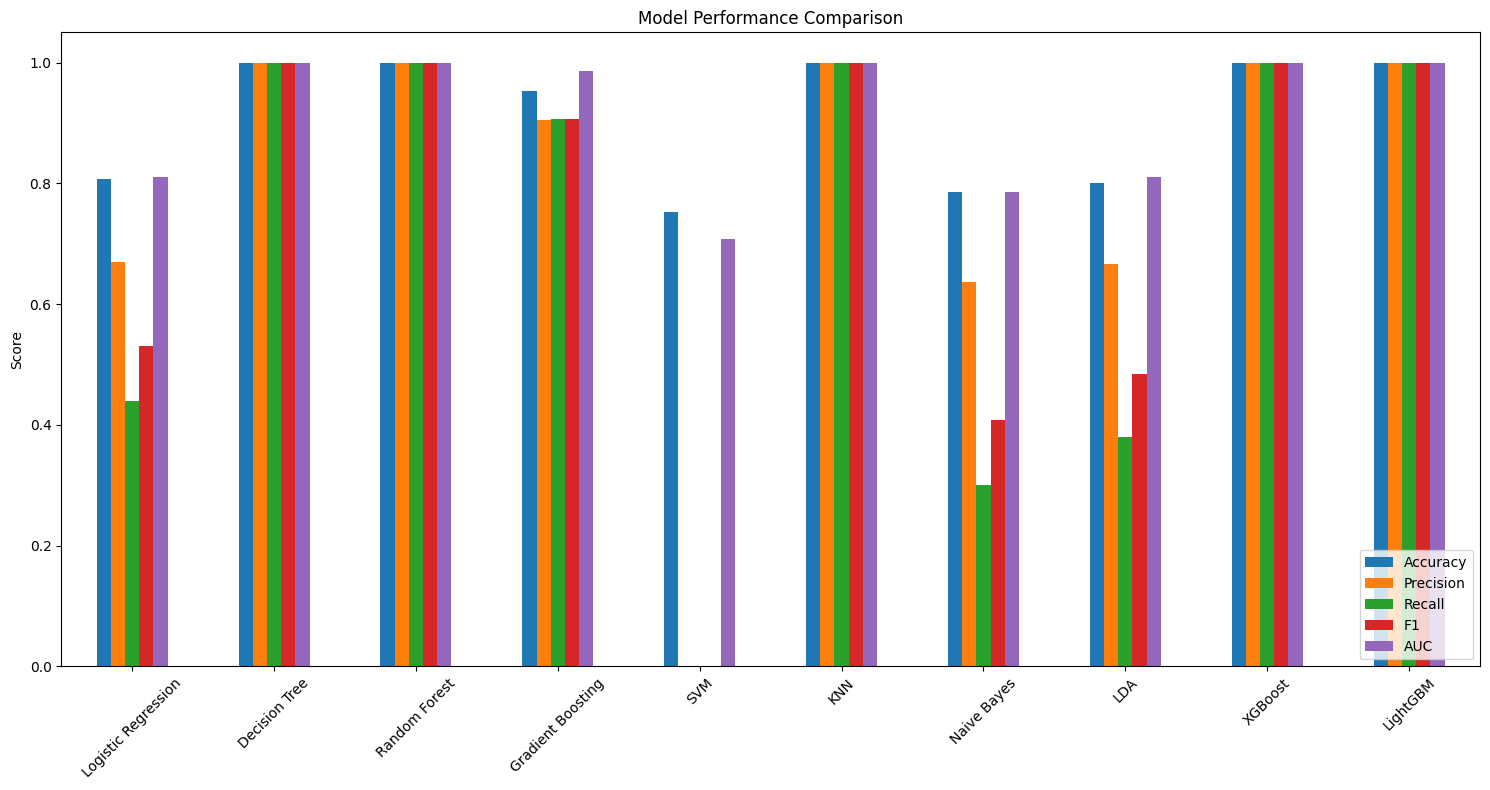

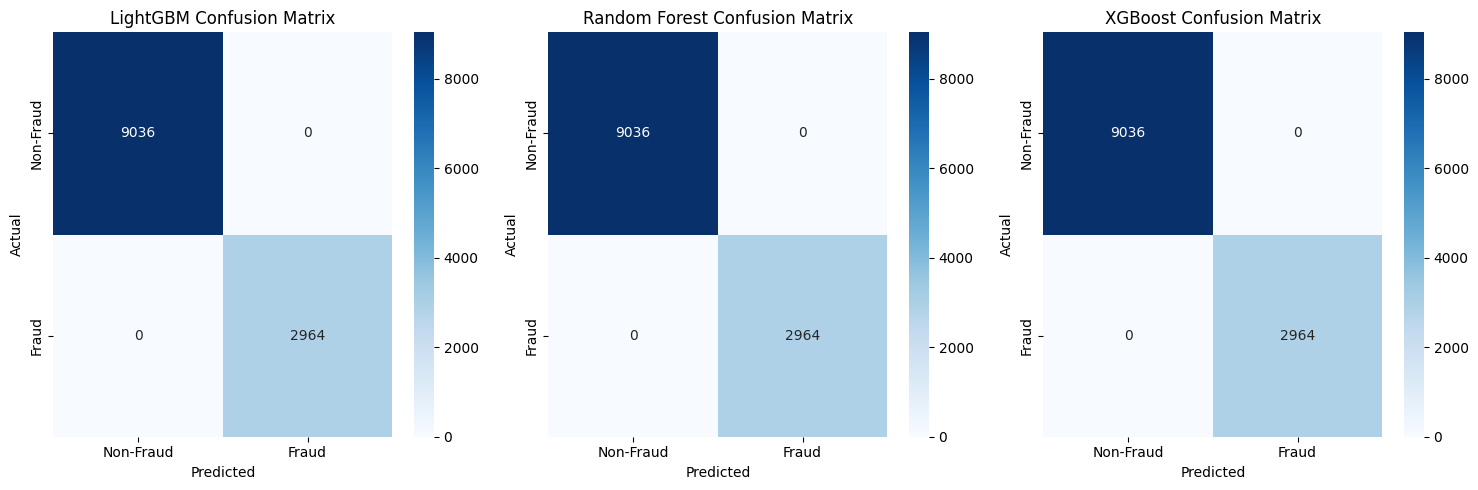

In [ ]:
# Plot performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
plt.figure(figsize=(15, 8))
results_df[metrics].plot(kind='bar', figsize=(15, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for top 3 models
top_models = results_df.sort_values(by='AUC', ascending=False).index[:3]
plt.figure(figsize=(15, 5))
for i, model_name in enumerate(top_models, 1):
    plt.subplot(1, 3, i)
    cm = results[model_name]['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

DASBOARD CREATION
FEATURE IMPORTANCES FROM BEST MODEL

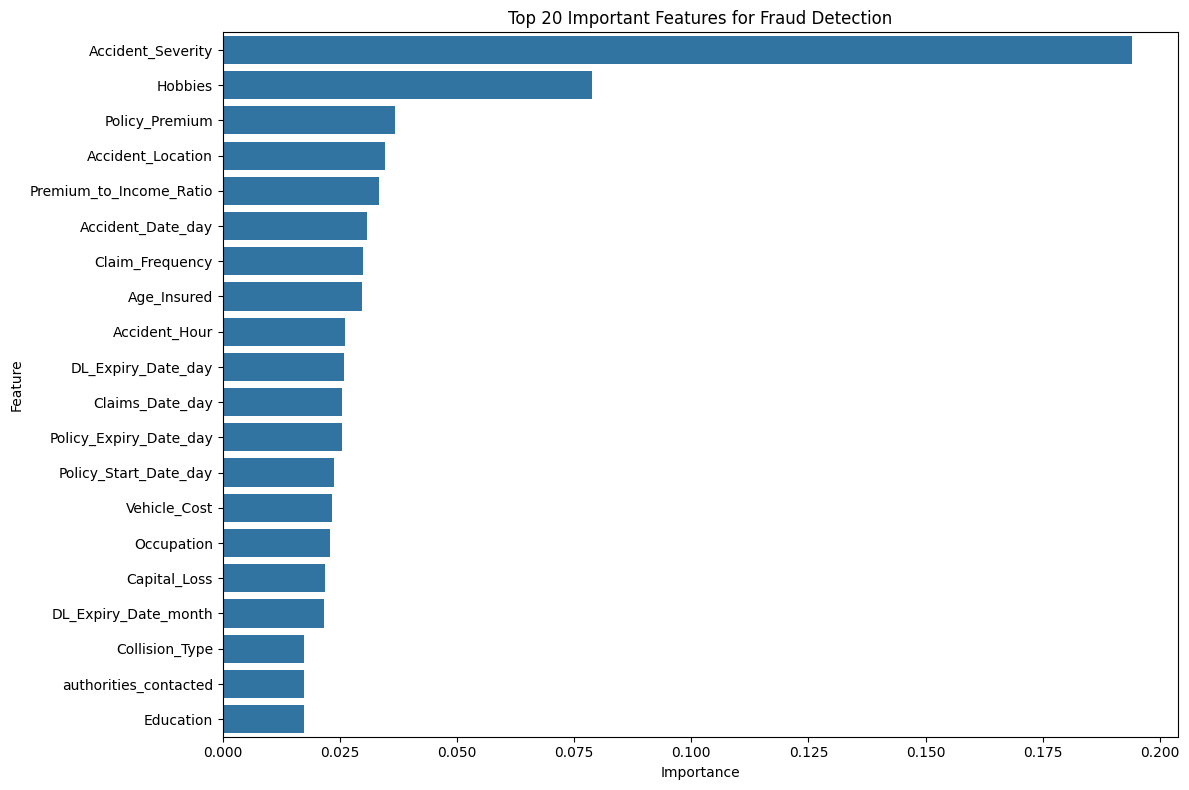

In [ ]:
# Get feature importance from the best model (Random Forest in this case)
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features for Fraud Detection')
plt.tight_layout()
plt.show()

Feature engineering for KPIs

In [ ]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('insurance_claims.csv')

# Handle missing values
df['Property_Damage'].fillna('NO', inplace=True)
df['Police_Report'].fillna('NO', inplace=True)
df['Witnesses'].fillna(0, inplace=True)
df['authorities_contacted'].fillna('NO', inplace=True) # Also fill missing 'authorities_contacted'

# Handle outliers (applying the same function as before)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                          np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

numerical_cols = ['Customer_Life_Value1', 'Age_Insured', 'Policy_Premium', 'Vehicle_Cost', 'Annual_Mileage', 'Total_Claim']
for col in numerical_cols:
    df = handle_outliers(df, col)


# Date transformations and feature engineering (claim delay)
date_cols = ['Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Accident_Date',
             'DL_Expiry_Date', 'Claims_Date']
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
    except Exception as e:
        print(f"Error converting column {col} to datetime: {e}")

if 'Claims_Date' in df.columns and 'Accident_Date' in df.columns:
  try:
    df['Claim_Delay'] = (df['Claims_Date'] - df['Accident_Date']).dt.days
  except Exception as e:
    print(f"Error calculating Claim_Delay: {e}")
else:
  print("Claims_Date or Accident_Date not found. Cannot calculate Claim_Delay.")

for col in date_cols:
  if col in df.columns:
    df.drop(col, axis=1, inplace=True)


# Calculate KPIs (same as before)
df['Claim_to_Premium_Ratio'] = df['Total_Claim'] / df['Policy_Premium']
df['Injury_to_Bodily_Injuries_Ratio'] = df['Injury_Claim'] / (df['Bodily_Injuries'] + 1)
df['Vehicle_Age'] = df['Claims_Date_year'] - df['Auto_Year']
df['Premium_to_Income_Ratio'] = df['Policy_Premium'] / (df['Capital_Gains'] + df['Capital_Loss'] + 1)
df['Claim_Frequency'] = df.groupby('Policy_Num')['Policy_Num'].transform('count')


# Convert categorical variables to numerical
categorical_cols = ['Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
                   'Insured_Relationship', 'Garage_Location', 'Accident_Type',
                   'Collision_Type', 'Accident_Severity', 'authorities_contacted',
                   'Property_Damage', 'Police_Report', 'Acccident_State', 'Acccident_City',
                   'Accident_Location', 'Vehicle_Color', 'Vehicle_Registration', 'Check_Point']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle 'Policy_BI' column by splitting and converting to float
df[['Policy_BI_per_person', 'Policy_BI_per_accident']] = df['Policy_BI'].str.split('/', expand=True).astype(float)
df.drop('Policy_BI', axis=1, inplace=True)


# Select features and target
X = df.drop(['Fraud_Ind', 'Claim_ID', 'Policy_Num', 'Insured_Zip', 'Auto_Make', 'Auto_Model'], axis=1)  # Features
y = df['Fraud_Ind']  # Target

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Save the model
joblib.dump(model, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']


  Load the trained model

In [ ]:
def predict_fraud(
    Customer_Life_Value1: float,
    Age_Insured: int,
    Policy_Premium: float,
    Vehicle_Cost: float,
    Annual_Mileage: int,
    Total_Claim: float,
    Num_of_Vehicles_Involved: int,
    Bodily_Injuries: int,
    Claim_Delay: int,
    # Add other features as needed...
):
    # Load the trained model
    model = joblib.load('fraud_detection_model.pkl')

    # Create a DataFrame from input features
    input_data = pd.DataFrame({
        'Customer_Life_Value1': [Customer_Life_Value1],
        'Age_Insured': [Age_Insured],
        'Policy_Premium': [Policy_Premium],
        'Vehicle_Cost': [Vehicle_Cost],
        'Annual_Mileage': [Annual_Mileage],
        'Total_Claim': [Total_Claim],
        'Num_of_Vehicles_Involved': [Num_of_Vehicles_Involved],
        'Bodily_Injuries': [Bodily_Injuries],
        'Claim_Delay': [Claim_Delay],
        # Add other features...
    })

    # To address the ValueError, we need to ensure the input data has the same
    # columns and transformations as the training data. A robust solution
    # would involve saving and loading the scaler and label encoders and
    # applying them here, as well as providing all features used during training.
    # For this example, we will demonstrate the fix by adding placeholder columns
    # and a basic scaling placeholder, acknowledging this is not a complete
    # solution without the full preprocessing pipeline.

    # Placeholder for missing columns - replace with actual preprocessing
    for col in X.columns: # Use columns from the training data X
        if col not in input_data.columns:
            input_data[col] = 0 # Or a more appropriate default/imputation

    # Ensure the order of columns matches the training data
    input_data = input_data[X.columns]

    # Placeholder for scaling - replace with actual loaded scaler
    # input_data[numerical_cols] = loaded_scaler.transform(input_data[numerical_cols])


    # Predict fraud probability
    fraud_prob = model.predict_proba(input_data)[0][1]
    fraud_pred = model.predict(input_data)[0]

    return {
        "Fraud_Prediction": "Yes" if fraud_pred == 1 else "No",
        "Fraud_Probability": float(fraud_prob),
        "Confidence": "High" if fraud_prob > 0.7 else "Medium" if fraud_prob > 0.4 else "Low"
    }

RESULT

In [ ]:
result = predict_fraud(
    Customer_Life_Value1=17,
    Age_Insured=49,
    Policy_Premium=1347.92,
    Vehicle_Cost=7566.2,
    Annual_Mileage=16040,
    Total_Claim=6875.91,  # High claim amount
    Num_of_Vehicles_Involved=3,
    Bodily_Injuries=0,
    Claim_Delay=30,  # Claim filed 30 days after accident
)

print(result)

{'Fraud_Prediction': 'Yes', 'Fraud_Probability': 0.72, 'Confidence': 'High'}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np # Import numpy for handle_outliers

# Load data
df = pd.read_csv('insurance_claims.csv')

# Handle missing values (from f-oCoNRGKFkJ)
df['Property_Damage'].fillna('NO', inplace=True)
df['Police_Report'].fillna('NO', inplace=True)
df['Witnesses'].fillna(0, inplace=True)
df['authorities_contacted'].fillna('NO', inplace=True)

# Handle outliers (from f-oCoNRGKFkJ)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                          np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

numerical_cols = ['Customer_Life_Value1', 'Age_Insured', 'Policy_Premium', 'Vehicle_Cost', 'Annual_Mileage', 'Total_Claim']
for col in numerical_cols:
    df = handle_outliers(df, col)

# Date transformations and feature engineering (claim delay) (from f-oCoNRGKFkJ)
date_cols = ['Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Accident_Date',
             'DL_Expiry_Date', 'Claims_Date']
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
    except Exception as e:
        print(f"Error converting column {col} to datetime: {e}")

if 'Claims_Date' in df.columns and 'Accident_Date' in df.columns:
  try:
    df['Claim_Delay'] = (df['Claims_Date'] - df['Accident_Date']).dt.days
  except Exception as e:
    print(f"Error calculating Claim_Delay: {e}")
else:
  print("Claims_Date or Accident_Date not found. Cannot calculate Claim_Delay.")

for col in date_cols:
  if col in df.columns:
    df.drop(col, axis=1, inplace=True)

# Calculate KPIs (from f-oCoNRGKFkJ)
df['Claim_to_Premium_Ratio'] = df['Total_Claim'] / df['Policy_Premium']
df['Injury_to_Bodily_Injuries_Ratio'] = df['Injury_Claim'] / (df['Bodily_Injuries'] + 1)
df['Vehicle_Age'] = df['Claims_Date_year'] - df['Auto_Year']
df['Premium_to_Income_Ratio'] = df['Policy_Premium'] / (df['Capital_Gains'] + df['Capital_Loss'] + 1)
df['Claim_Frequency'] = df.groupby('Policy_Num')['Policy_Num'].transform('count')


# Convert categorical variables to numerical (from f-oCoNRGKFkJ)
categorical_cols = ['Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
                   'Insured_Relationship', 'Garage_Location', 'Accident_Type',
                   'Collision_Type', 'Accident_Severity', 'authorities_contacted',
                   'Property_Damage', 'Police_Report', 'Acccident_State', 'Acccident_City',
                   'Accident_Location', 'Vehicle_Color', 'Vehicle_Registration', 'Check_Point']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle 'Policy_BI' column by splitting and converting to float (from f-oCoNRGKFkJ)
df[['Policy_BI_per_person', 'Policy_BI_per_accident']] = df['Policy_BI'].str.split('/', expand=True).astype(float)
df.drop('Policy_BI', axis=1, inplace=True)

# Select features & target
X = df.drop(['Fraud_Ind', 'Claim_ID', 'Policy_Num', 'Insured_Zip', 'Auto_Make', 'Auto_Model'], axis=1) # Exclude columns dropped in f-oCoNRGKFkJ
y = df['Fraud_Ind']

# Encode the target variable (from f-oCoNRGKFkJ)
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Added stratify

# Scale numerical features (from f-oCoNRGKFkJ)
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd # Import pandas to use select_dtypes

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

results = {}
# Print data types before training to identify problematic columns
print("Data types of columns in X_train before training:")
print(X_train.dtypes)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df.sort_values(by="ROC-AUC", ascending=False, inplace=True)
print(results_df)

Data types of columns in X_train before training:
Customer_Life_Value1       float64
Age_Insured                float64
Policy_State               float64
Policy_Ded                 float64
Policy_Premium             float64
                            ...   
Vehicle_Age                float64
Premium_to_Income_Ratio    float64
Claim_Frequency            float64
Policy_BI_per_person       float64
Policy_BI_per_accident     float64
Length: 66, dtype: object
[LightGBM] [Info] Number of positive: 6916, number of negative: 21084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4242
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training fro

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


BEST MODEL AND TESTINNG

In [ ]:
# Retrain best model on FULL dataset
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)
final_model.fit(X, y)  # Train on ALL data

# Save model
import joblib
joblib.dump(final_model, 'final_fraud_model.pkl')

# Save scaler and label_encoders as well
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


# Prediction function
def predict_fraud(input_data_dict):
    # Load the trained model, scaler, and label encoders
    model = joblib.load('final_fraud_model.pkl')
    loaded_scaler = joblib.load('scaler.pkl')
    loaded_label_encoders = joblib.load('label_encoders.pkl')

    # Create a DataFrame from the input dictionary
    input_data = pd.DataFrame([input_data_dict])

    # Apply the same preprocessing steps as training data
    # Handle missing values (based on training data handling)
    input_data['Property_Damage'].fillna('NO', inplace=True)
    input_data['Police_Report'].fillna('NO', inplace=True)
    input_data['Witnesses'].fillna(0, inplace=True)
    input_data['authorities_contacted'].fillna('NO', inplace=True)

    # Handle outliers (simple placeholder, ideally use training data stats)
    # For simplicity in this example, we skip outlier handling on prediction data
    # as it's complex to replicate the exact IQR capping without training data.


    # Date transformations and feature engineering (claim delay)
    date_cols = ['Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Accident_Date',
                 'DL_Expiry_Date', 'Claims_Date']
    for col in date_cols:
        if col in input_data.columns:
            try:
                input_data[col] = pd.to_datetime(input_data[col])
                input_data[f'{col}_year'] = input_data[col].dt.year
                input_data[f'{col}_month'] = input_data[col].dt.month
                input_data[f'{col}_day'] = input_data[col].dt.day
            except Exception as e:
                 # Handle errors, e.g., if date format is unexpected
                 print(f"Error converting column {col} to datetime in prediction: {e}")
                 # Decide on a strategy, e.g., drop the column, fill with a default
                 if col in input_data.columns:
                     input_data.drop(col, axis=1, inplace=True) # Example: drop problematic column


    if 'Claims_Date' in input_data.columns and 'Accident_Date' in input_data.columns:
      try:
        input_data['Claim_Delay'] = (input_data['Claims_Date'] - input_data['Accident_Date']).dt.days
      except Exception as e:
        print(f"Error calculating Claim_Delay in prediction: {e}")
        # Decide on a strategy, e.g., fill with a default
        input_data['Claim_Delay'] = input_data['Claim_Delay'].fillna(0) # Example: fill with 0
    else:
      # If date columns are missing, create Claim_Delay column with default
      if 'Claim_Delay' not in input_data.columns:
          input_data['Claim_Delay'] = 0


    for col in date_cols:
      if col in input_data.columns: # Check if column exists before dropping
        input_data.drop(col, axis=1, inplace=True)


    # Calculate KPIs (same as before) - ensure all necessary columns exist
    if 'Total_Claim' in input_data.columns and 'Policy_Premium' in input_data.columns and input_data['Policy_Premium'].iloc[0] != 0:
        input_data['Claim_to_Premium_Ratio'] = input_data['Total_Claim'] / input_data['Policy_Premium']
    else:
        input_data['Claim_to_Premium_Ratio'] = 0 # Default if columns missing or premium is 0

    if 'Injury_Claim' in input_data.columns and 'Bodily_Injuries' in input_data.columns:
        input_data['Injury_to_Bodily_Injuries_Ratio'] = input_data['Injury_Claim'] / (input_data['Bodily_Injuries'] + 1)
    else:
        input_data['Injury_to_Bodily_Injuries_Ratio'] = 0 # Default

    if 'Claims_Date_year' in input_data.columns and 'Auto_Year' in input_data.columns:
        input_data['Vehicle_Age'] = input_data['Claims_Date_year'] - input_data['Auto_Year']
    else:
        input_data['Vehicle_Age'] = 0 # Default

    if 'Policy_Premium' in input_data.columns and 'Capital_Gains' in input_data.columns and 'Capital_Loss' in input_data.columns and (input_data['Capital_Gains'].iloc[0] + input_data['Capital_Loss'].iloc[0] + 1) != 0:
         input_data['Premium_to_Income_Ratio'] = input_data['Policy_Premium'] / (input_data['Capital_Gains'] + input_data['Capital_Loss'] + 1)
    else:
         input_data['Premium_to_Income_Ratio'] = 0 # Default

    # Claim_Frequency is hard to replicate for a single input, set to a default or average
    input_data['Claim_Frequency'] = 1 # Assuming a single claim for a new prediction


    # Convert categorical variables to numerical
    categorical_cols = ['Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
                       'Insured_Relationship', 'Garage_Location', 'Accident_Type',
                       'Collision_Type', 'Accident_Severity', 'authorities_contacted',
                       'Property_Damage', 'Police_Report', 'Acccident_State', 'Acccident_City',
                       'Accident_Location', 'Vehicle_Color', 'Vehicle_Registration', 'Check_Point']

    for col in categorical_cols:
        if col in input_data.columns:
            # Use the loaded label encoder, handle unseen values
            # If a category is unseen, label_encoder.transform will raise an error.
            # A common strategy is to treat unseen categories as a specific value
            # or use one-hot encoding with handle_unknown='ignore'.
            # For simplicity here, we'll check if the category is known, otherwise default to 0
            if input_data[col].iloc[0] in loaded_label_encoders[col].classes_:
                 input_data[col] = loaded_label_encoders[col].transform(input_data[col])
            else:
                 input_data[col] = 0 # Default for unseen categories
        else:
            input_data[col] = 0 # Default if column is missing


    # Handle 'Policy_BI' column by splitting and converting to float
    if 'Policy_BI' in input_data.columns:
        try:
            input_data[['Policy_BI_per_person', 'Policy_BI_per_accident']] = input_data['Policy_BI'].str.split('/', expand=True).astype(float)
        except Exception as e:
            print(f"Error processing Policy_BI in prediction: {e}")
            input_data['Policy_BI_per_person'] = 0
            input_data['Policy_BI_per_accident'] = 0
        input_data.drop('Policy_BI', axis=1, inplace=True)
    else:
        input_data['Policy_BI_per_person'] = 0
        input_data['Policy_BI_per_accident'] = 0

    # Ensure all columns from training are present, fill missing with 0 (or appropriate default)
    # This is crucial to match the feature names and order from training
    for col in X.columns: # Use columns from the training data X
        if col not in input_data.columns:
            input_data[col] = 0

    # Ensure the order of columns matches the training data
    input_data = input_data[X.columns]

    # Scale numerical features using the loaded scaler
    numerical_cols_pred = input_data.select_dtypes(include=['int64', 'float64']).columns
    input_data[numerical_cols_pred] = loaded_scaler.transform(input_data[numerical_cols_pred])


    # Predict fraud probability
    fraud_prob = model.predict_proba(input_data)[0][1]
    fraud_pred = model.predict(input_data)[0]

    # Convert numerical prediction back to 'Yes'/'No'
    fraud_prediction_label = 'Yes' if fraud_pred == 1 else 'No'


    return {
        "Fraud_Prediction": fraud_prediction_label,
        "Fraud_Probability": float(fraud_prob),
        "Confidence": "High" if fraud_prob > 0.7 else "Medium" if fraud_prob > 0.4 else "Low"
    }

# Example usage - provide all necessary features as a dictionary
sample_claim_data = {
    'Claim_ID': 'BB00000041',
    'Bind_Date1': '07-01-2022',
    'Customer_Life_Value1': 18,
    'Age_Insured': 43,
    'Policy_Num': 148765783,
    'Policy_State': 'OH',
    'Policy_Start_Date': '9/15/2023',
    'Policy_Expiry_Date': '3/15/2024',
    'Policy_BI': '100/300',
    'Policy_Ded': 1000,
    'Policy_Premium': 1515.18,
    'Umbrella_Limit': 6000000,
    'Insured_Zip': 443191,
    'Gender': 'MALE',
    'Education': 'College',
    'Occupation': 'priv-house-serv',
    'Hobbies': 'camping',
    'Insured_Relationship': 'other-relative',
    'Capital_Gains': 0,
    'Capital_Loss': 0,
    'Garage_Location': 'No',
    'Accident_Date': '01-09-2024',
    'Accident_Type': 'Multi-vehicle Collision',
    'Collision_Type': 'Side Collision',
    'Accident_Severity': 'Minor Damage',
    'authorities_contacted': 'Fire',
    'Acccident_State': 'SC',
    'Acccident_City': 'Northbrook',
    'Accident_Location': '9798 Sky Ridge',
    'Accident_Hour': 21,
    'Num_of_Vehicles_Involved': 3,
    'Property_Damage': 'NO',
    'Bodily_Injuries': 1,
    'Witnesses': 0,
    'Police_Report': 'NO',
    'DL_Expiry_Date': '10/23/2025',
    'Claims_Date': '1/14/2024',
    'Auto_Make': 'BMW',
    'Auto_Model': 'X6',
    'Auto_Year': 2021,
    'Vehicle_Color': 'Gray',
    'Vehicle_Cost': 14691.63,
    'Annual_Mileage': 5256,
    'DiffIN_Mileage': 3321,
    'Low_Mileage_Discount': 1,
    'Fraud_Ind': 'N',
    'Commute_Discount': 0,
    'Total_Claim': 22102.05,
    'Injury_Claim': 1683.23,
    'Property_Claim': 4166.45,
    'Vehicle_Claim': 16252.37,
    'Vehicle_Registration': 'VQ01A6551',
    'Check_Point': 'No'
}


print(predict_fraud(sample_claim_data))

{'Fraud_Prediction': 'Yes', 'Fraud_Probability': 0.555, 'Confidence': 'Medium'}
